#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Создадим-признаки-для-обучения-моделей" data-toc-modified-id="Создадим-признаки-для-обучения-моделей-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Создадим признаки для обучения моделей</a></span></li><li><span><a href="#Разделение-данных" data-toc-modified-id="Разделение-данных-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Разделение данных</a></span></li><li><span><a href="#Создадим-функцию-для-кроссвалидации-временных-рядов,-cv-выборка-для-временных-рядов-с-помощью-TimeSeriesSplit" data-toc-modified-id="Создадим-функцию-для-кроссвалидации-временных-рядов,-cv-выборка-для-временных-рядов-с-помощью-TimeSeriesSplit-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Создадим функцию для кроссвалидации временных рядов, cv выборка для временных рядов с помощью TimeSeriesSplit</a></span></li><li><span><a href="#Проведем-обучение-моделей-следующими-регрессорами:" data-toc-modified-id="Проведем-обучение-моделей-следующими-регрессорами:-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Проведем обучение моделей следующими регрессорами:</a></span><ul class="toc-item"><li><span><a href="#LGBMRegressor" data-toc-modified-id="LGBMRegressor-3.4.1"><span class="toc-item-num">3.4.1&nbsp;&nbsp;</span>LGBMRegressor</a></span></li><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-3.4.2"><span class="toc-item-num">3.4.2&nbsp;&nbsp;</span>LinearRegression</a></span></li><li><span><a href="#DecisionTreeRegressor" data-toc-modified-id="DecisionTreeRegressor-3.4.3"><span class="toc-item-num">3.4.3&nbsp;&nbsp;</span>DecisionTreeRegressor</a></span></li><li><span><a href="#CatBoostRegressor" data-toc-modified-id="CatBoostRegressor-3.4.4"><span class="toc-item-num">3.4.4&nbsp;&nbsp;</span>CatBoostRegressor</a></span></li></ul></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#LGBMRegressor" data-toc-modified-id="LGBMRegressor-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>LGBMRegressor</a></span></li><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>LinearRegression</a></span></li><li><span><a href="#DecisionTreeRegressor" data-toc-modified-id="DecisionTreeRegressor-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>DecisionTreeRegressor</a></span></li><li><span><a href="#CatBoostRegressor" data-toc-modified-id="CatBoostRegressor-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>CatBoostRegressor</a></span></li></ul></li><li><span><a href="#Результаты" data-toc-modified-id="Результаты-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Результаты</a></span></li><li><span><a href="#ВЫВОДЫ" data-toc-modified-id="ВЫВОДЫ-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>ВЫВОДЫ</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

## Подготовка

In [1]:
# Подключение библиотек
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split

from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv("/datasets/taxi.csv", index_col=[0], parse_dates=[0]) #загрузка данных
df = df.resample('1H').sum() # ресемплирование по одному часу
df.sort_index(inplace=True) # сортировка
display('Количество нулевых значений:', df.isnull().sum())
display(df.info())
display('Пример данных (5 первых строк):',df.head())

'Количество нулевых значений:'

num_orders    0
dtype: int64

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


None

'Пример данных (5 первых строк):'

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


## Анализ

<AxesSubplot:xlabel='datetime'>

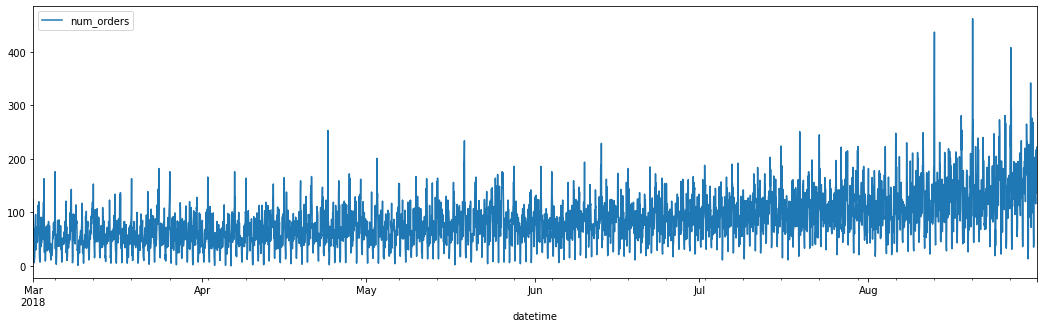

In [3]:
figsize = (18,5)
df.plot(figsize=figsize)

**Для большей наглядности применим скользящую среднюю**

<AxesSubplot:xlabel='datetime'>

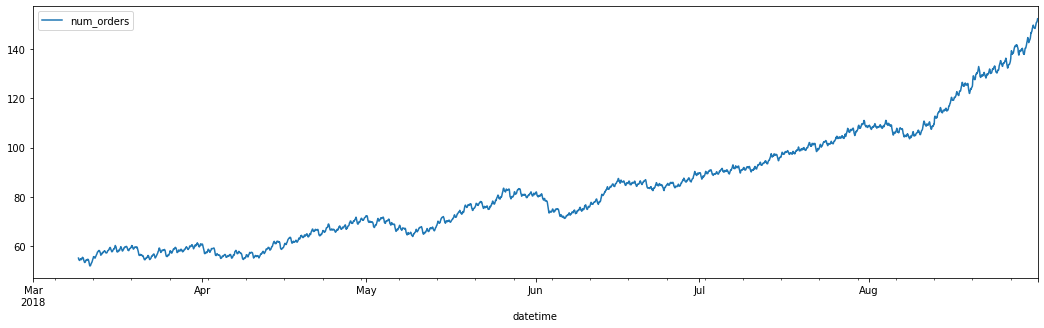

In [4]:
df.rolling(200).mean().plot(figsize=figsize)

**Исходя из графика, можем сделать вывод о возрастании количества заказов**

В частности можем проследить 2 закономерности:
 - в середине месяца преимущественно больше заказов чем в начале/конце;
 - количество заказов к летнему сезону увеличивается (предположительно из-за сезона отпусков).
 
**Проведем декомпозицию по тренду и сезонности**

<AxesSubplot:title={'center':'Остаток'}, xlabel='datetime'>

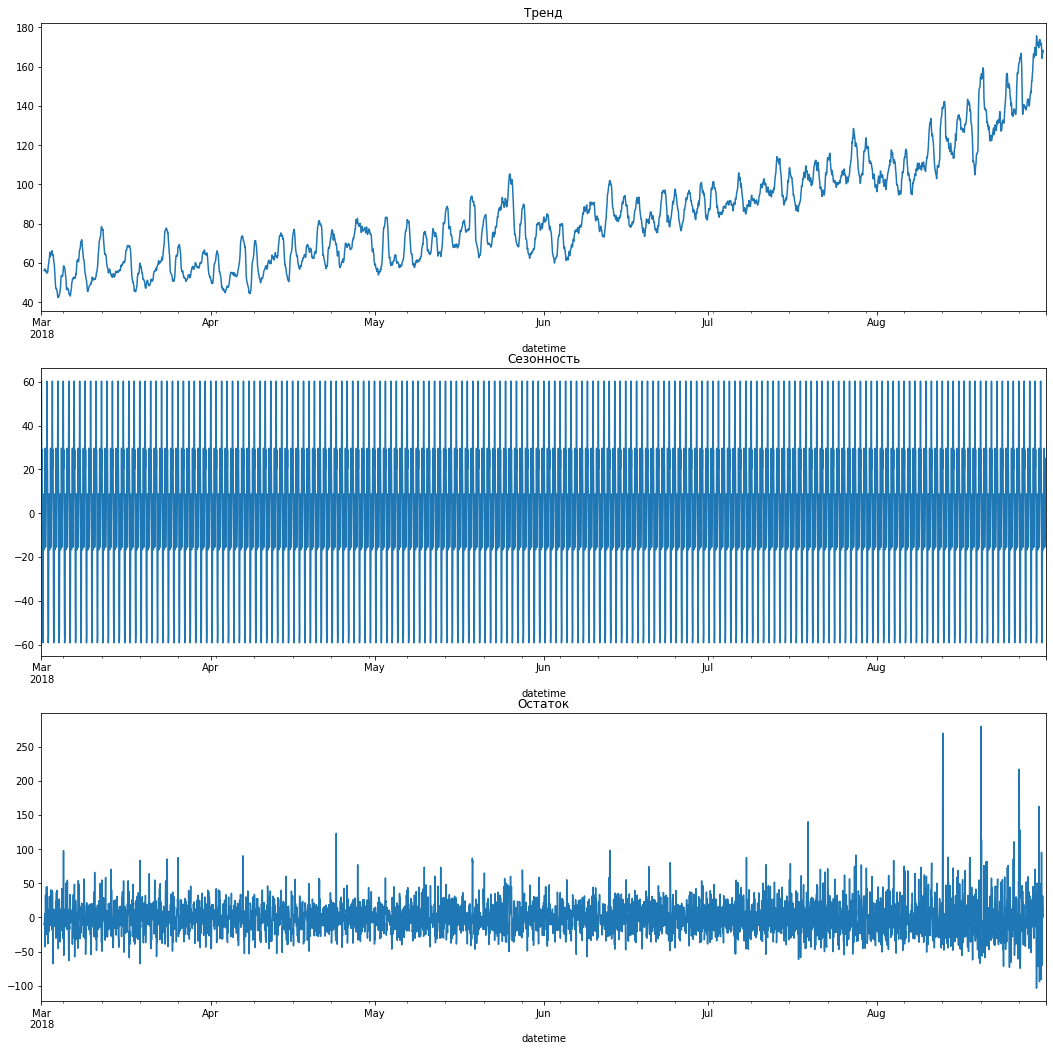

In [5]:
decomposed = seasonal_decompose(df)

plt.figure(figsize=(18, 18))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca(), title='Тренд')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca(), title='Сезонность')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca(), title='Остаток')

**Исходя из графиков**:

 - **Тренд** подтверждает выводы полученные по скользящей средней (среднее количество заказов летнему сезону увеличивается);
 - **Сезонность** показывает цикличность показателей временного ряда в данных по дням, но по году из-за временных рамок предоставленных данных, мы выводов получить не можем.
 
**Для более глубокого анализа рассмотрим промежуток август месяц**

<AxesSubplot:title={'center':'Остаток'}, xlabel='datetime'>

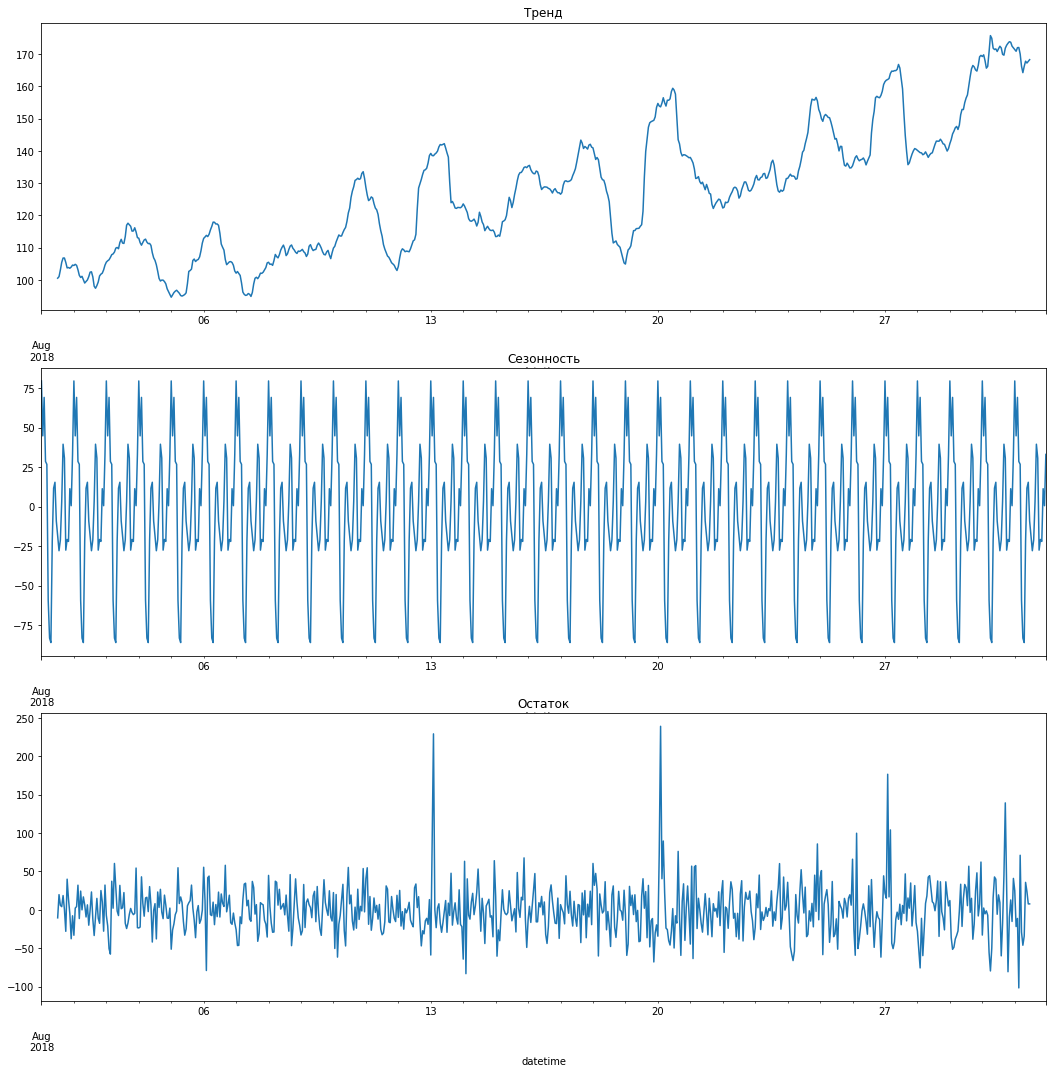

In [6]:
decomposed = seasonal_decompose(df['2018-08-01':'2018-08-31'])

plt.figure(figsize=(18, 18))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca(), title='Тренд')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca(), title='Сезонность')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca(), title='Остаток')

**Исходя из анализа месячного промежутка** видим:
 - **Тренд** идет на возрастание;
 - **Сезонность** демонстрирует утренний спад и всплески (особенно значительные в ночное время)

## Обучение

### Создадим признаки для обучения моделей

 - месяц
 - день
 - день недели
 - час
 - лаги(отставания)
 - скользящее среднее

In [7]:
def make_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [8]:
make_features(df, 8, 7)
display(df)

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,rolling_mean
datetime,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,1,3,4,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,8,31,4,19,207.0,217.0,197.0,116.0,133.0,166.0,136.0,167.0,167.428571
2018-08-31 20:00:00,154,8,31,4,20,136.0,207.0,217.0,197.0,116.0,133.0,166.0,136.0,167.428571
2018-08-31 21:00:00,159,8,31,4,21,154.0,136.0,207.0,217.0,197.0,116.0,133.0,166.0,165.714286


### Разделение данных

In [9]:
train, test = train_test_split(df, shuffle=False, test_size=0.1, random_state=12345)
train = train.dropna()

target_tr = train['num_orders']
features_tr = train.drop('num_orders', axis=1)
target_t = test['num_orders']
features_t = test.drop('num_orders', axis=1)

### Создадим функцию для кроссвалидации временных рядов, cv выборка для временных рядов с помощью TimeSeriesSplit

In [10]:
def cv_time_series_rmse(regressor, data, target_column, n_splits, max_train_size):
    tscv = TimeSeriesSplit(n_splits = n_splits, max_train_size = max_train_size)
    RMSE = 0.0
    for train_index, test_index in tscv.split(data):
        train = data.iloc[train_index]
        test = data.iloc[test_index]
        train_features = train.drop(target_column, axis=1)
        train_target = train[target_column]
        test_features = test.drop(target_column, axis=1)
        test_target = test[target_column]
        regressor.fit(features_tr, target_tr)
        RMSE += mean_squared_error(target_t, regressor.predict(features_t)) ** 0.5
    return RMSE / n_splits

In [11]:
cv_train_test_split = (train.shape[0] * 4 //5)
cv_splits = 3
cv_time_series_rmse(regressor=LinearRegression(), 
                    data=train, 
                    target_column='num_orders', 
                    n_splits=cv_splits, 
                    max_train_size=cv_train_test_split)

52.62225831758381

### Проведем обучение моделей следующими регрессорами:

 - LGBMRegressor
 - LinearRegression
 - DecisionTreeRegressor
 - CatBoostRegressor

#### LGBMRegressor

In [12]:
%%time

hyperp = [{'learning_rate':[x/10 for x in range(1, 6)], 'random_state':[12345]}]
print('Настройка гипер-параметров для RMSE')
clf = GridSearchCV(LGBMRegressor(), hyperp, scoring='neg_mean_squared_error', cv=TimeSeriesSplit())
clf.fit(features_tr, target_tr)
print('Лучшие параметры:')
best_p_LGBMR = clf.best_params_
print(best_p_LGBMR)
print('Таблица значений:')
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print('%0.6f for %r'% ((mean*-1)** 0.5, params))

Настройка гипер-параметров для RMSE
Лучшие параметры:
{'learning_rate': 0.1, 'random_state': 12345}
Таблица значений:
25.256156 for {'learning_rate': 0.1, 'random_state': 12345}
26.128559 for {'learning_rate': 0.2, 'random_state': 12345}
26.538080 for {'learning_rate': 0.3, 'random_state': 12345}
27.062627 for {'learning_rate': 0.4, 'random_state': 12345}
27.794967 for {'learning_rate': 0.5, 'random_state': 12345}
CPU times: user 23.6 s, sys: 297 ms, total: 23.9 s
Wall time: 24.3 s


In [13]:
%%time

LGBMRegressor().set_params(**best_p_LGBMR)
print('Обучение для RMSE')
cv_RMSE_LGBMR = cv_time_series_rmse(LGBMRegressor(), 
                                    data=train, 
                                    target_column='num_orders', 
                                    n_splits=cv_splits, 
                                    max_train_size=cv_train_test_split)
print('Среднее RMSE для CV LGBMRegressor =', cv_RMSE_LGBMR)

Обучение для RMSE
Среднее RMSE для CV LGBMRegressor = 43.12135648597171
CPU times: user 2.64 s, sys: 33 ms, total: 2.67 s
Wall time: 2.79 s


#### LinearRegression

In [14]:
%%time

print('Обучение для RMSE')
cv_RMSE_LR = cv_time_series_rmse(LinearRegression(), 
                                 data=train, 
                                 target_column='num_orders', 
                                 n_splits=cv_splits, 
                                 max_train_size=cv_train_test_split)
print('Среднее RMSE для CV LinearRegression =', cv_RMSE_LR)

Обучение для RMSE
Среднее RMSE для CV LinearRegression = 52.62225831758381
CPU times: user 31.4 ms, sys: 28.7 ms, total: 60.1 ms
Wall time: 94.1 ms


#### DecisionTreeRegressor

In [15]:
%%time

max_depth_list = [x for x in range(2, 21)]
hyperparams = [{'criterion':['mse'], 'max_depth':max_depth_list,'random_state':[12345]}]
print('Настройка гипер-параметров для RMSE')
clf = GridSearchCV(DecisionTreeRegressor(), hyperparams, scoring='neg_mean_squared_error', cv=TimeSeriesSplit())
clf.fit(features_tr, target_tr)
print('Лучшие параметры:')
best_params_DTR = clf.best_params_
print(best_params_DTR)
print('Таблица значений:')
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))

Настройка гипер-параметров для RMSE
Лучшие параметры:
{'criterion': 'mse', 'max_depth': 8, 'random_state': 12345}
Таблица значений:
34.860071 for {'criterion': 'mse', 'max_depth': 2, 'random_state': 12345}
32.606665 for {'criterion': 'mse', 'max_depth': 3, 'random_state': 12345}
32.689896 for {'criterion': 'mse', 'max_depth': 4, 'random_state': 12345}
32.333107 for {'criterion': 'mse', 'max_depth': 5, 'random_state': 12345}
31.458065 for {'criterion': 'mse', 'max_depth': 6, 'random_state': 12345}
30.980466 for {'criterion': 'mse', 'max_depth': 7, 'random_state': 12345}
30.618426 for {'criterion': 'mse', 'max_depth': 8, 'random_state': 12345}
30.868831 for {'criterion': 'mse', 'max_depth': 9, 'random_state': 12345}
31.959712 for {'criterion': 'mse', 'max_depth': 10, 'random_state': 12345}
32.280719 for {'criterion': 'mse', 'max_depth': 11, 'random_state': 12345}
32.952149 for {'criterion': 'mse', 'max_depth': 12, 'random_state': 12345}
33.111395 for {'criterion': 'mse', 'max_depth': 13,

In [16]:
%%time

DecisionTreeRegressor().set_params(**best_params_DTR)
print('Обучение для RMSE')
cv_RMSE_DTR = cv_time_series_rmse(DecisionTreeRegressor(), 
                                  data=train, 
                                  target_column='num_orders', 
                                  n_splits=cv_splits, 
                                  max_train_size=cv_train_test_split)
print('Среднее RMSE для CV DecisionTreeRegressor =', cv_RMSE_DTR)

Обучение для RMSE
Среднее RMSE для CV DecisionTreeRegressor = 52.694884581667246
CPU times: user 122 ms, sys: 0 ns, total: 122 ms
Wall time: 125 ms


#### CatBoostRegressor

In [17]:
%%time
print('Обучение CatBoostRegressor для RMSE')
cv_RMSE_CBR = cv_time_series_rmse(CatBoostRegressor(verbose=False), 
                                  data=train, 
                                  target_column='num_orders', 
                                  n_splits=cv_splits, 
                                  max_train_size=cv_train_test_split)
print('Среднее RMSE для CV CatBoostRegressor =', cv_RMSE_CBR)

Обучение CatBoostRegressor для RMSE
Среднее RMSE для CV CatBoostRegressor = 43.153673851434625
CPU times: user 7.85 s, sys: 308 ms, total: 8.16 s
Wall time: 10.8 s


## Тестирование

### LGBMRegressor

CPU times: user 905 ms, sys: 9.44 ms, total: 915 ms
Wall time: 833 ms


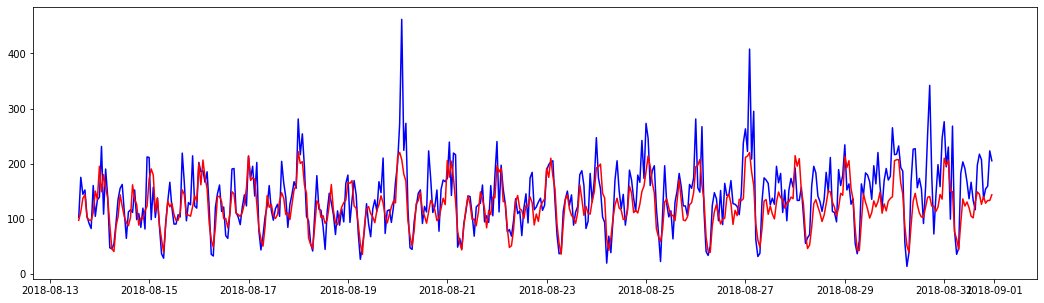

In [18]:
%%time

model = LGBMRegressor()
#model.set_params(**best_p_LGBMR)
model.fit(features_tr, target_tr)
target_predict = model.predict(features_t)
f_RMSE_LGBMR = mean_squared_error(target_t, target_predict) ** 0.5

plt.figure(figsize=figsize)
plt.plot(target_t.index, target_t, 'b-', 
         target_t.index, target_predict, 'r-')

### LinearRegression

CPU times: user 35.7 ms, sys: 24.2 ms, total: 59.8 ms
Wall time: 21.8 ms


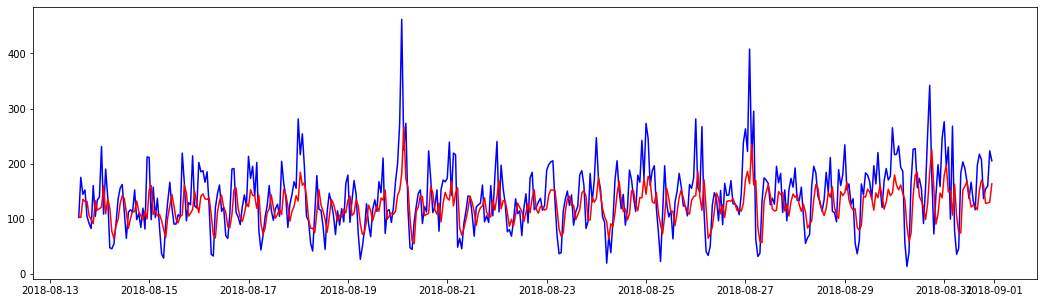

In [19]:
%%time

model = LinearRegression()
model.fit(features_tr, target_tr)
target_predict = model.predict(features_t)
f_RMSE_LR = mean_squared_error(target_t, target_predict) ** 0.5

plt.figure(figsize=figsize)
plt.plot(target_t.index, target_t, 'b-', 
         target_t.index, target_predict,  'r-')

### DecisionTreeRegressor

CPU times: user 141 ms, sys: 0 ns, total: 141 ms
Wall time: 148 ms


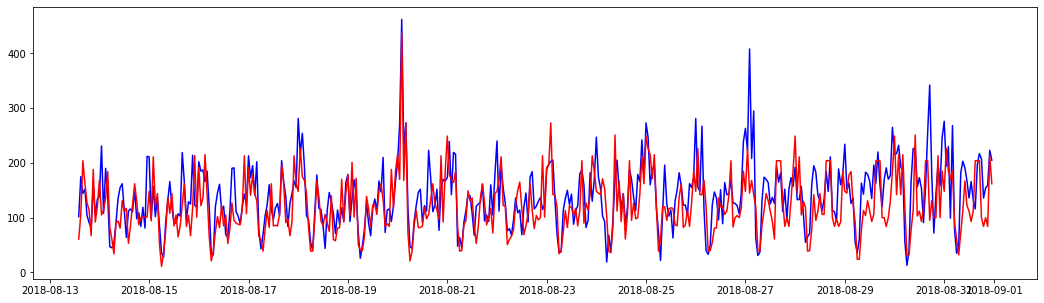

In [20]:
%%time

model = DecisionTreeRegressor()
#model.set_params(**best_params_DTR)
model.fit(features_tr, target_tr)
target_predict = model.predict(features_t)
f_RMSE_DTR = mean_squared_error(target_t, target_predict) ** 0.5

plt.figure(figsize=figsize)
plt.plot(target_t.index, target_t, 'b-', 
         target_t.index, target_predict,  'r-')

### CatBoostRegressor

CPU times: user 2.66 s, sys: 95.3 ms, total: 2.76 s
Wall time: 3.63 s


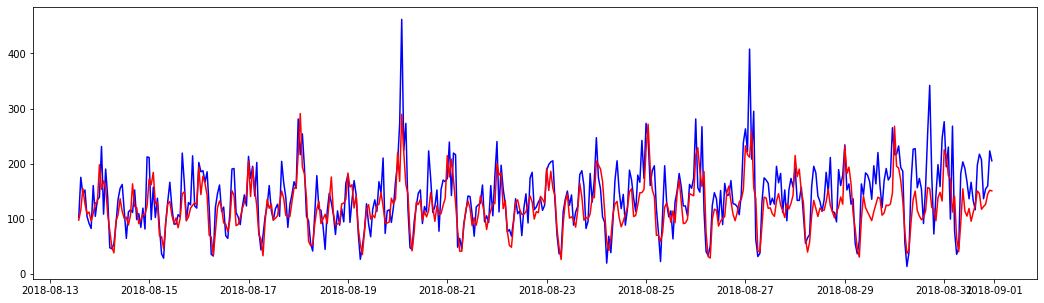

In [21]:
%%time

model = CatBoostRegressor(verbose=False)
model.fit(features_tr, target_tr)
target_predict = model.predict(features_t)
f_RMSE_CBR = mean_squared_error(target_t, target_predict) ** 0.5

plt.figure(figsize=figsize)
plt.plot(target_t.index, target_t, 'b-', 
         target_t.index, target_predict,  'r-')

## Результаты


In [22]:
index = ['LGBMRegressor',
         'LinearRegression',
         'DecisionTreeRegressor',
         'CatBoostRegressor']
data = {'RMSE на CV':[cv_RMSE_LGBMR,
                      cv_RMSE_LR,
                      cv_RMSE_DTR,
                      cv_RMSE_CBR],
        'RMSE модели на тестовой выборке':[f_RMSE_LGBMR,
                                           f_RMSE_LR,
                                           f_RMSE_DTR,
                                           f_RMSE_CBR]}

scores_data = pd.DataFrame(data=data, index=index)
scores_data['Рейтинг RMSE на CV'] = (scores_data['RMSE на CV'].min()/scores_data['RMSE на CV'])
scores_data['Выполнение задачи'] = scores_data['RMSE модели на тестовой выборке'] < 48.0
display(scores_data)

,RMSE на CV,RMSE модели на тестовой выборке,Рейтинг RMSE на CV,Выполнение задачи
LGBMRegressor,43.121356,43.121356,1.000000,True
LinearRegression,52.622258,52.622258,0.819451,False
DecisionTreeRegressor,52.694885,49.890876,0.818321,False
CatBoostRegressor,43.153674,43.153674,0.999251,True


## ВЫВОДЫ

Были изучены способы предсказания временных рядов на основе регрессоров.

Следует отметить, что исходные данные имеют очень много шумов, влияющих на основные регрессоры.

Использован CatBoostRegressor без указания параметров, т.к. в нем уже встроен алгоритм поиска наилучших параметров.

**Лучшие показатели** получены у моделей **LGBMRegressor(43,12) и CatBoostRegressor(43,15)**, что соответствует требуемому значению метрики RMSE на тестовой выборке < 48.